In [15]:
!pip install torch torch-geometric
!wget https://data.pyg.org/whl/torch-2.5.0%2Bcu121/torch_cluster-1.6.3%2Bpt25cu121-cp310-cp310-linux_x86_64.whl
!mv torch_cluster-1.6.3%2Bpt25cu121-cp310-cp310-linux_x86_64.whl torch_cluster-1.6.3+pt25cu121-cp310-cp310-linux_x86_64.whl
!pip install /content/torch_cluster-1.6.3+pt25cu121-cp310-cp310-linux_x86_64.whl
!unzip /content/codebert_finetuned.zip -d .
!unzip /content/processed_repositories.zip -d .

In [3]:
from transformers import RobertaTokenizer, RobertaModel
import torch

class SolidityEmbeddings:
    def __init__(self):
        self.tokenizer = RobertaTokenizer.from_pretrained('.')
        self.model = RobertaModel.from_pretrained('.')
        self.model.eval()

    def __call__(self, text):
        tokens = self.tokenizer(text, return_tensors="pt", padding=True, truncation=True)
        with torch.no_grad():
            outputs = self.model(**tokens)
        # Mean pool across the sequence dimension for fixed-size embedding
        return outputs.last_hidden_state.mean(dim=1).squeeze(0)

solidityembeddings = SolidityEmbeddings()

Some weights of RobertaModel were not initialized from the model checkpoint at . and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Build dataset

In [30]:
import os
import json
import torch
from torch_geometric.data import HeteroData

repo_dir = "processed_repositories"
pyg_datasets = []

# Used for finding full path based on name of contract
def find_string_with_substring(strings, substring):
    return [s for s in strings if substring in s]

for repo_name in os.listdir(repo_dir)[:50]:
    repo_path = os.path.join(repo_dir, repo_name)

    # For each repository
    nodes = {} #function name: {id,code}
    edges = {
        ('function', 'parent_contract', 'function'): [], #in list there will be ids of function with this relationship
        ('function', 'internal_call', 'function'): [],
        ('function', 'high_level_call', 'function'): [],
        ('function', 'library_call', 'function'): [],
        ('function', 'low_level_call', 'function'): []
    }
    node_id=0
    full_paths = []
    # Walk through the directory tree
    for subdir, _, files in os.walk(repo_path):
        for file_name in files:
            full_path = os.path.join(subdir, file_name)
            full_paths.append(full_path)
    print(repo_name, len(full_paths))

    # Remember all nodes
    for node_id, full_path in enumerate(full_paths):

        # Load the function code JSON
        with open(full_path, 'r') as f:
            function_data = json.load(f)

        # Every node has key its path
        nodes[full_path] = {
            "id": node_id,
            "code": solidityembeddings(function_data["Code"])
        }

    # Remember all edges
    for full_path in full_paths:
        # Load the function code JSON
        with open(full_path, 'r') as f:
            function_data = json.load(f)
        node_id = nodes[full_path]['id']

        # Create edges based on the calls
        for parent_contract in function_data["Parent Contracts"]:
            parent_contract_path = find_string_with_substring(full_paths,parent_contract) # find real path of file
            if parent_contract_path!=[] and parent_contract_path in nodes: #check if function is processed into .txt
                edges[('function', 'parent_contract', 'function')].append((nodes[parent_contract_path[0]]["id"], node_id))

        for internal_call in function_data["Internal Calls"]:
            internal_call_path = find_string_with_substring(full_paths,internal_call)
            if internal_call_path!=[] and internal_call_path[0] in nodes:
                edges[('function', 'internal_call', 'function')].append((node_id, nodes[internal_call_path[0]]["id"]))

        high_level_calls = function_data["High-Level Calls"]
        if len(high_level_calls) != 0 and isinstance(high_level_calls[0], list):
            high_level_calls = [] # unpack list of lists
            for lst in high_level_calls:
              for elem in lst:
                high_level_calls.append(elem)
        for high_level_call in high_level_calls:
            high_level_call_path = find_string_with_substring(full_paths,high_level_call)
            if high_level_call_path!=[] and high_level_call_path[0] in nodes:
                edges[('function', 'high_level_call', 'function')].append((node_id, nodes[high_level_call_path[0]]["id"]))

        for library_call in function_data["Library Calls"]:
            library_call_path = find_string_with_substring(full_paths,library_call)
            if library_call_path!=[] and library_call_path[0] in nodes:
                edges[('function', 'library_call', 'function')].append((node_id, nodes[library_call_path[0]]["id"]))

        for low_level_call in function_data["Low-Level Calls"]:
            low_level_call_path = find_string_with_substring(full_paths,low_level_call)
            if low_level_call_path!=[] and low_level_call_path[0] in nodes:
                edges[('function', 'low_level_call', 'function')].append((node_id, nodes[low_level_call_path[0]]["id"]))

    data = HeteroData()
    # Create node type function
    codes_encoded=[nodes[func]["code"].unsqueeze(-1) for func in nodes]
    codes_encoded=torch.cat(codes_encoded,1).T #Num_nodes, 768
    data['function'].x =torch.tensor(codes_encoded, dtype=torch.float)
    print('nodes',len(nodes))
    print('edges',edges)
    # Populate edges
    for edge_type, edge_list in edges.items():
        if edge_list:
            data[edge_type].edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()

    if edges[('function', 'high_level_call', 'function')]!=[] or edges[('function', 'internal_call', 'function')]!=[] or edges[('function', 'parent_contract', 'function')]!=[] or edges[('function', 'library_call', 'function')]!=[]:
        pyg_datasets.append(data)
    else:
      print("Have no edges")

2022-06-yieldy 42


<ipython-input-30-2dd28a777eb5>:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data['function'].x =torch.tensor(codes_encoded, dtype=torch.float)


nodes 42
edges {('function', 'parent_contract', 'function'): [], ('function', 'internal_call', 'function'): [], ('function', 'high_level_call', 'function'): [], ('function', 'library_call', 'function'): [], ('function', 'low_level_call', 'function'): []}
Have no edges
2023-08-dopex 128
nodes 128
edges {('function', 'parent_contract', 'function'): [], ('function', 'internal_call', 'function'): [(0, 37), (1, 43), (3, 43), (6, 4), (7, 43), (8, 43), (8, 32), (8, 18), (9, 43), (10, 43), (10, 37), (11, 43), (12, 43), (13, 43), (15, 43), (16, 43), (17, 43), (24, 6), (24, 26), (24, 28), (24, 43), (24, 10), (27, 43), (27, 6), (27, 28), (27, 0), (28, 43), (28, 37), (29, 43), (30, 43), (34, 32), (34, 8), (34, 43), (35, 43), (36, 43), (38, 43), (39, 6), (39, 27), (39, 26), (39, 43), (39, 10), (40, 43), (45, 32), (45, 8), (45, 43), (50, 49), (52, 57), (52, 60), (53, 50), (54, 20), (57, 62), (60, 55), (62, 49), (65, 67), (65, 53), (67, 67), (68, 68), (70, 20), (73, 63), (75, 67), (77, 67), (81, 96),

Check the dataset

In [31]:
torch.save(pyg_datasets, 'repositories_graph.pt')
print(len(pyg_datasets))

35


In [32]:
subset_dict={
    'function':torch.tensor([29])
}
print(pyg_datasets[1].subgraph(subset_dict))

HeteroData(
  function={ x=[1, 768] },
  (function, internal_call, function)={ edge_index=[2, 0] }
)


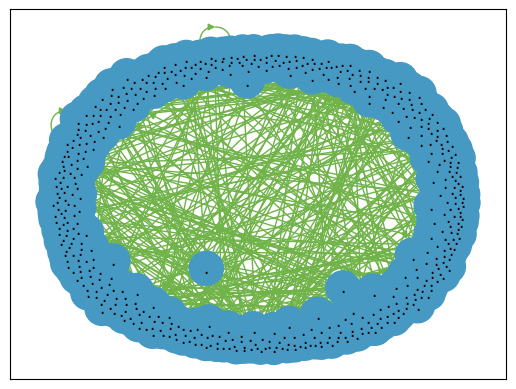

In [6]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.utils import to_networkx

def draw_graph(graph):
    graph = to_networkx(graph, to_undirected=False)
    node_type_colors = {
        "function": "#4599C3",
    }
    node_colors = []
    labels = {}
    for node_num, attrs_dict in graph.nodes(data=True):
        node_type = "function"
        color = node_type_colors[node_type]
        node_colors.append(color)
        labels[node_num] = "."

    edge_type_colors = {
          ('function', 'internal_call', 'function'): "#70B349",
          ('function', 'high_level_call', 'function'): "#DFB825",
    }

    edge_colors = []
    for from_node, to_node, attrs in graph.edges(data=True):
        edge_type = attrs["type"]
        color = edge_type_colors[edge_type]

        graph.edges[from_node, to_node]["color"] = color
        edge_colors.append(color)

    # Draw the graph
    pos = nx.spring_layout(graph, k=2)
    nx.draw_networkx(
        graph,
        pos=pos,
        labels=labels,
        with_labels=True,
        node_color=node_colors,
        edge_color=edge_colors,
        node_size=600,
    )
    plt.show()
draw_graph(pyg_datasets[1])

In [33]:
from torch_geometric import transforms as T

transform = T.Compose([
    T.RemoveIsolatedNodes()
])
pyg_datasets_modified=transform(pyg_datasets)
for pyg_dataset in pyg_datasets_modified:
    print(pyg_dataset.num_edges)
    print(pyg_dataset.num_nodes)
    print(f'Number of features: {pyg_dataset.num_features}')
    print(pyg_dataset.node_types)
    print(pyg_dataset.edge_types)
    print(pyg_dataset)

97
73
Number of features: {'function': 768}
['function']
[('function', 'internal_call', 'function')]
HeteroData(
  function={ x=[73, 768] },
  (function, internal_call, function)={ edge_index=[2, 97] }
)
435
295
Number of features: {'function': 768}
['function']
[('function', 'internal_call', 'function')]
HeteroData(
  function={ x=[295, 768] },
  (function, internal_call, function)={ edge_index=[2, 435] }
)
861
658
Number of features: {'function': 768}
['function']
[('function', 'internal_call', 'function')]
HeteroData(
  function={ x=[658, 768] },
  (function, internal_call, function)={ edge_index=[2, 861] }
)
178
158
Number of features: {'function': 768}
['function']
[('function', 'internal_call', 'function')]
HeteroData(
  function={ x=[158, 768] },
  (function, internal_call, function)={ edge_index=[2, 178] }
)
78
79
Number of features: {'function': 768}
['function']
[('function', 'internal_call', 'function')]
HeteroData(
  function={ x=[79, 768] },
  (function, internal_call, fun

In [8]:
pyg_datasets_modified[1][('function', 'internal_call', 'function')]

{'edge_index': tensor([[  1,   2,   2,   4,   7,   7,   8,  10,  10,  10,  11,  12,  12,  12,
          16,  16,  16,  18,  18,  18,  19,  19,  20,  20,  20,  20,  21,  21,
          21,  22,  24,  24,  26,  26,  28,  28,  30,  30,  30,  31,  32,  32,
          32,  32,  33,  33,  34,  34,  34,  34,  34,  35,  35,  35,  35,  35,
          36,  36,  36,  37,  37,  37,  37,  37,  37,  37,  38,  39,  40,  40,
          40,  41,  41,  43,  44,  44,  44,  46,  47,  48,  48,  49,  50,  50,
          51,  51,  51,  51,  51,  51,  51,  51,  52,  52,  53,  53,  54,  54,
          55,  57,  57,  58,  60,  60,  61,  61,  63,  64,  66,  68,  68,  70,
          71,  72,  75,  76,  77,  79,  80,  81,  82,  83,  84,  85,  86,  87,
          88,  89,  90,  91,  92,  93,  94,  96,  97,  98,  99, 101, 102, 104,
         104, 105, 105, 108, 109, 109, 113, 115, 116, 116, 117, 118, 120, 121,
         121, 122, 123, 124, 125, 126, 127, 127, 128, 129, 130, 131, 132, 137,
         137, 137, 138, 138, 140, 140

In [86]:
import torch
from torch_geometric.utils import k_hop_subgraph

def sample_from_graph_ensure(graph,num_nodes):
    def sample_from_graph(graph, num_nodes):
        graph_amount_nodes = graph.num_nodes

        if num_nodes > graph_amount_nodes:
            num_nodes=graph_amount_nodes

        # Perform a random walk to collect nodes
        edge_types = graph.edge_types
        random_type = torch.randint(0, len(edge_types), (1,)).item()
        edge_index = graph[edge_types[random_type]].edge_index

        # Ensure the random node is present in the edge_index
        valid_nodes = torch.unique(edge_index)
        random_node = valid_nodes[torch.randint(0, len(valid_nodes), (1,))].item()

        # Extract the k-hop subgraph
        subgraph_nodes, subgraph_edge_index, _, _ = k_hop_subgraph(random_node, 1, edge_index, num_nodes=graph_amount_nodes)

        return subgraph_nodes, subgraph_edge_index

    subgraph_nodes, subgraph_edge_index=sample_from_graph(graph,num_nodes)
    num_tries=0
    success=False
    while not success:
        # idk it gives not specified num nodes sometimes
        subgraph_nodes, subgraph_edge_index=sample_from_graph(graph,num_nodes)
        if len(subgraph_nodes)==num_nodes:
            success=True
        num_tries+=1
        if num_tries%100==0 and not success:
            num_nodes-=1

    subset_dict={
        'function':torch.tensor(subgraph_nodes.tolist())
    }

    return graph.subgraph(subset_dict)

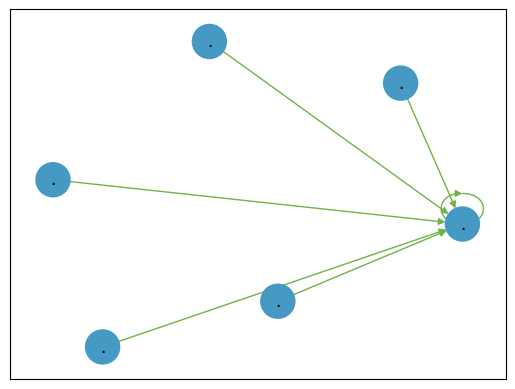

HeteroData(
  function={ x=[6, 768] },
  (function, internal_call, function)={ edge_index=[2, 6] }
)


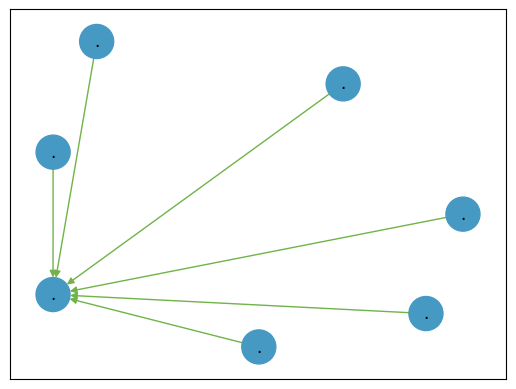

HeteroData(
  function={ x=[7, 768] },
  (function, internal_call, function)={ edge_index=[2, 6] }
)


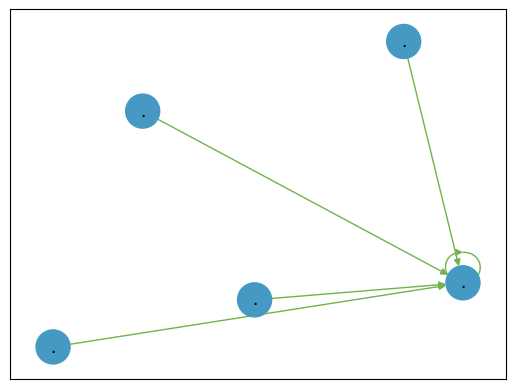

HeteroData(
  function={ x=[5, 768] },
  (function, internal_call, function)={ edge_index=[2, 5] }
)


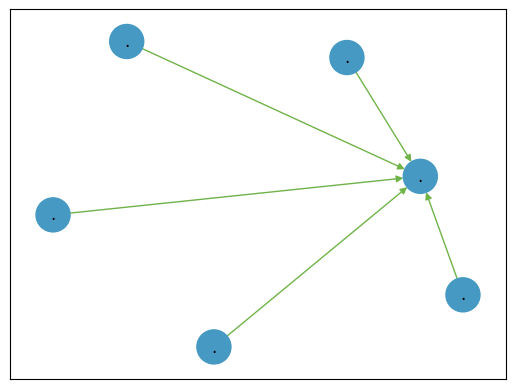

HeteroData(
  function={ x=[6, 768] },
  (function, internal_call, function)={ edge_index=[2, 5] }
)


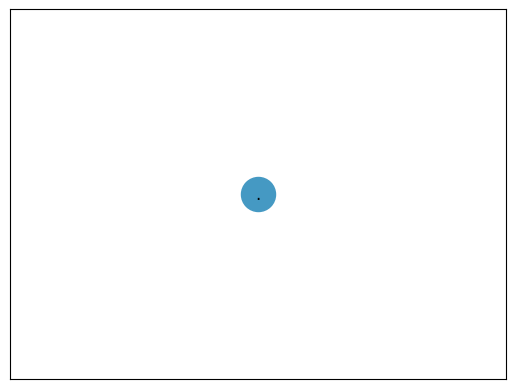

HeteroData(
  function={ x=[1, 768] },
  (function, internal_call, function)={ edge_index=[2, 0] }
)


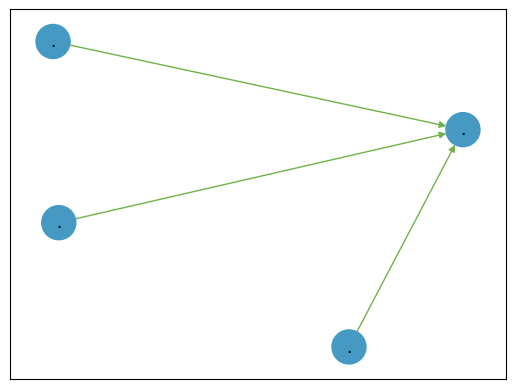

HeteroData(
  function={ x=[4, 768] },
  (function, internal_call, function)={ edge_index=[2, 3] }
)


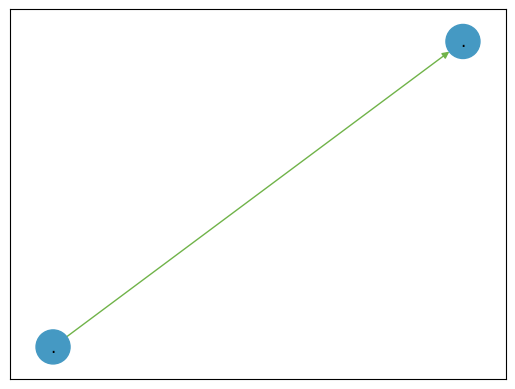

HeteroData(
  function={ x=[2, 768] },
  (function, internal_call, function)={ edge_index=[2, 1] }
)


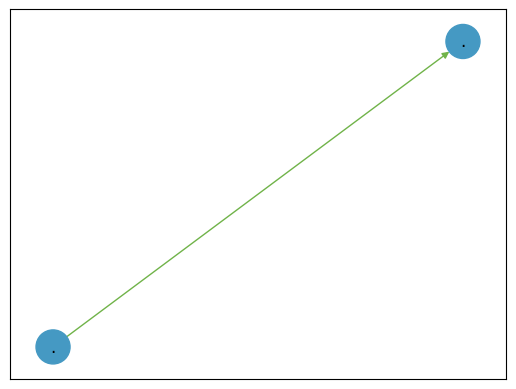

HeteroData(
  function={ x=[2, 768] },
  (function, internal_call, function)={ edge_index=[2, 1] }
)


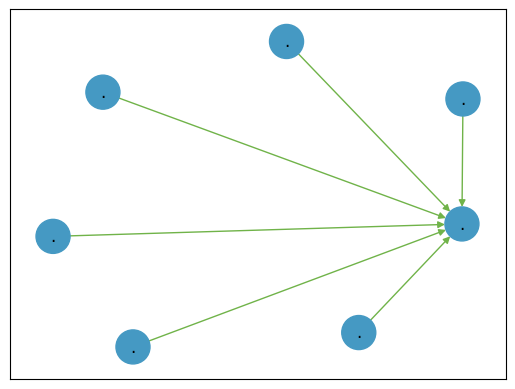

HeteroData(
  function={ x=[7, 768] },
  (function, internal_call, function)={ edge_index=[2, 6] }
)


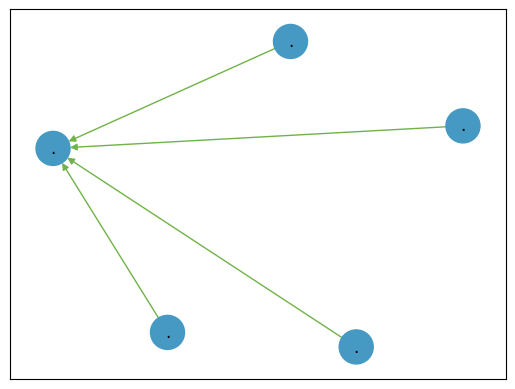

HeteroData(
  function={ x=[5, 768] },
  (function, internal_call, function)={ edge_index=[2, 4] }
)


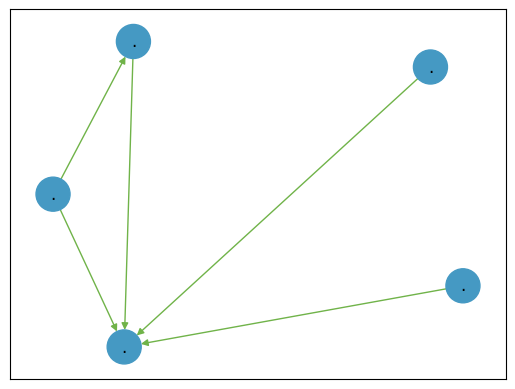

HeteroData(
  function={ x=[5, 768] },
  (function, internal_call, function)={ edge_index=[2, 5] }
)


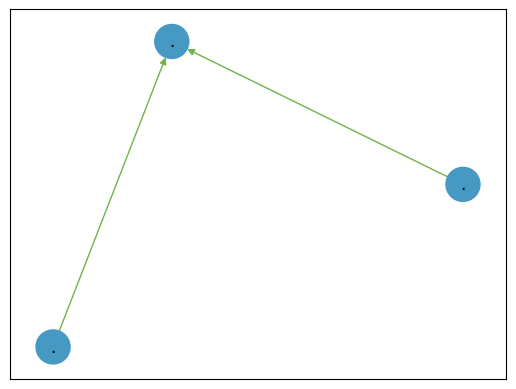

HeteroData(
  function={ x=[3, 768] },
  (function, internal_call, function)={ edge_index=[2, 2] }
)


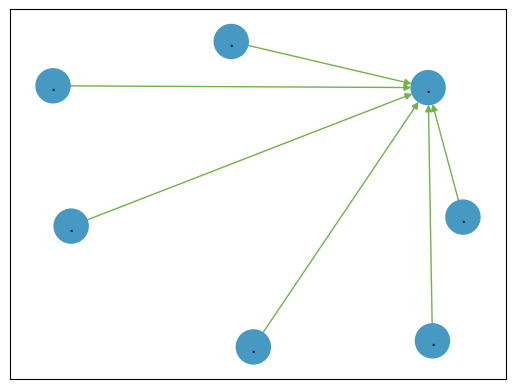

HeteroData(
  function={ x=[7, 768] },
  (function, internal_call, function)={ edge_index=[2, 6] }
)


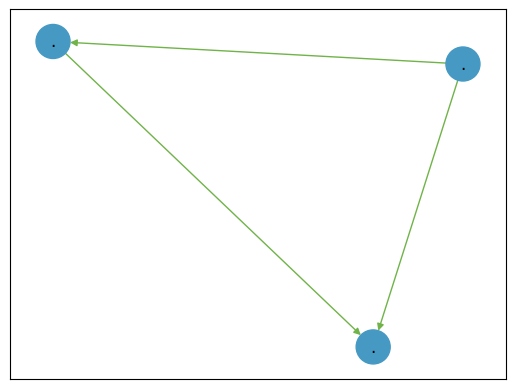

HeteroData(
  function={ x=[3, 768] },
  (function, internal_call, function)={ edge_index=[2, 3] }
)


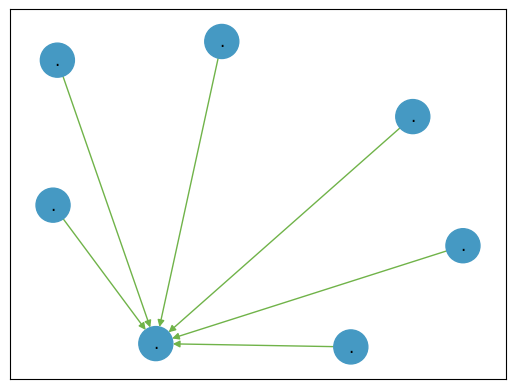

HeteroData(
  function={ x=[7, 768] },
  (function, internal_call, function)={ edge_index=[2, 6] }
)


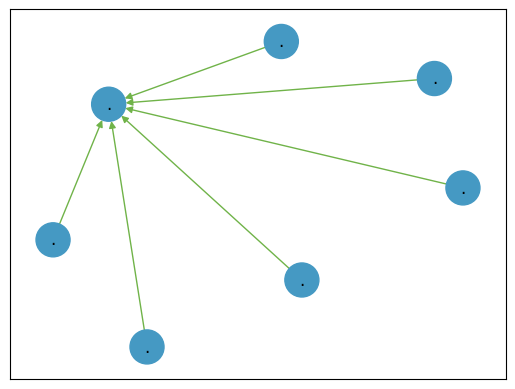

HeteroData(
  function={ x=[7, 768] },
  (function, internal_call, function)={ edge_index=[2, 6] }
)


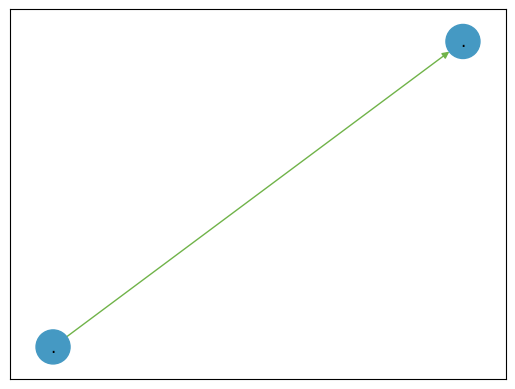

HeteroData(
  function={ x=[2, 768] },
  (function, internal_call, function)={ edge_index=[2, 1] }
)


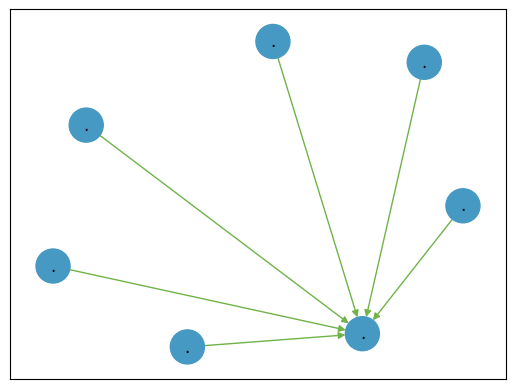

HeteroData(
  function={ x=[7, 768] },
  (function, internal_call, function)={ edge_index=[2, 6] }
)


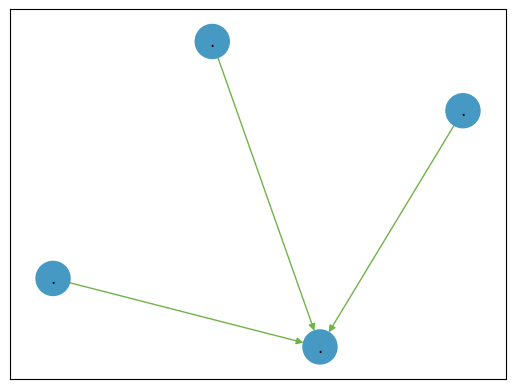

HeteroData(
  function={ x=[4, 768] },
  (function, internal_call, function)={ edge_index=[2, 3] }
)


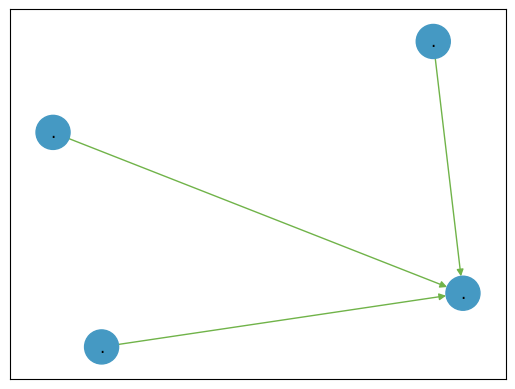

HeteroData(
  function={ x=[4, 768] },
  (function, internal_call, function)={ edge_index=[2, 5] }
)


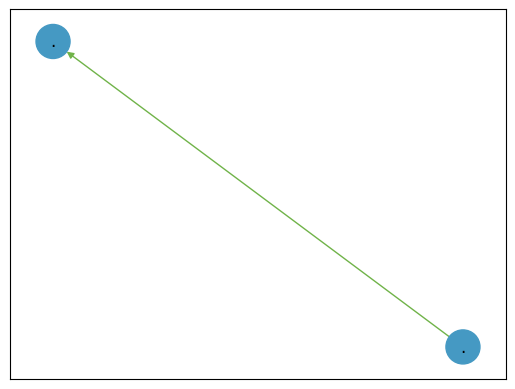

HeteroData(
  function={ x=[2, 768] },
  (function, internal_call, function)={ edge_index=[2, 1] }
)


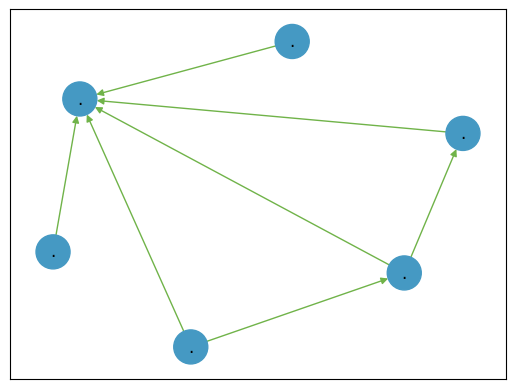

HeteroData(
  function={ x=[6, 768] },
  (function, internal_call, function)={ edge_index=[2, 7] }
)


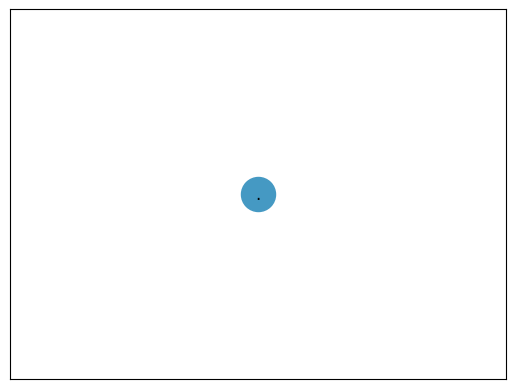

HeteroData(
  function={ x=[1, 768] },
  (function, internal_call, function)={ edge_index=[2, 0] }
)


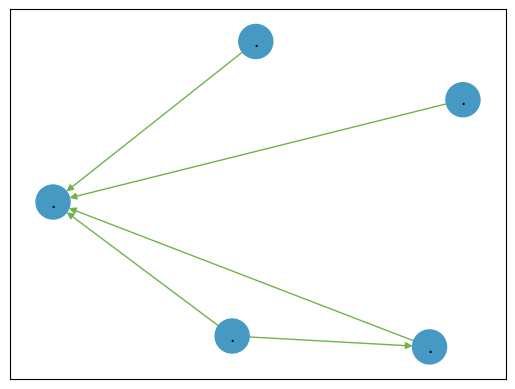

HeteroData(
  function={ x=[5, 768] },
  (function, internal_call, function)={ edge_index=[2, 5] }
)


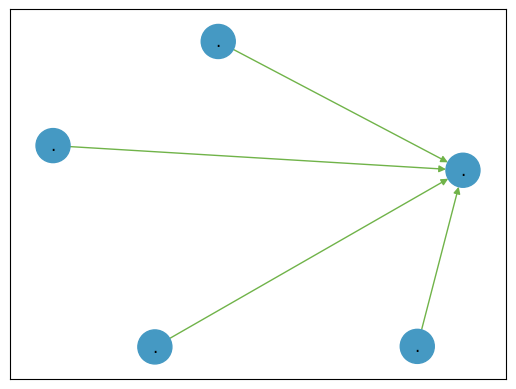

HeteroData(
  function={ x=[5, 768] },
  (function, internal_call, function)={ edge_index=[2, 4] }
)


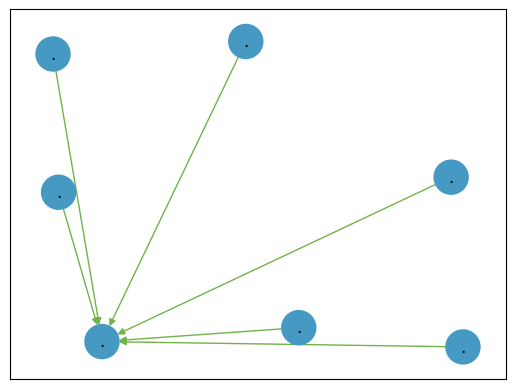

HeteroData(
  function={ x=[7, 768] },
  (function, internal_call, function)={ edge_index=[2, 6] }
)


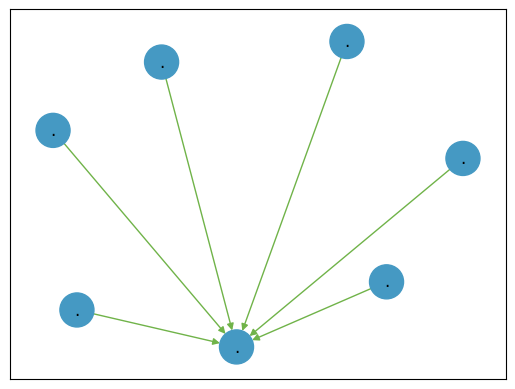

HeteroData(
  function={ x=[7, 768] },
  (function, internal_call, function)={ edge_index=[2, 6] }
)


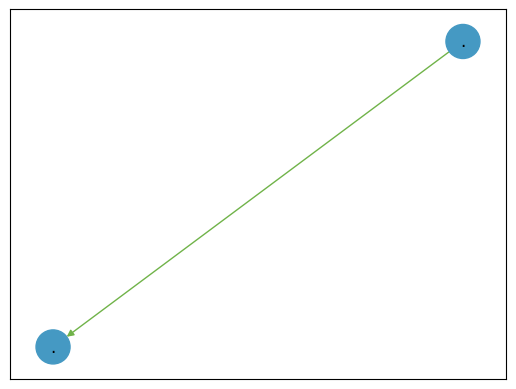

HeteroData(
  function={ x=[2, 768] },
  (function, internal_call, function)={ edge_index=[2, 1] }
)


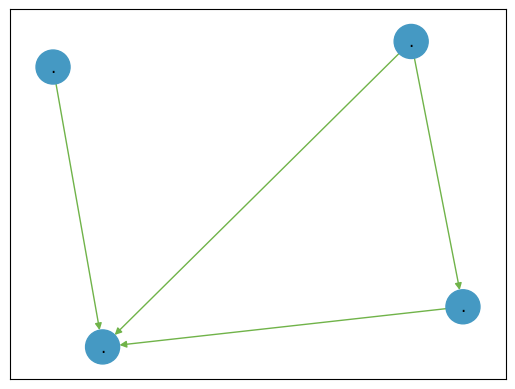

HeteroData(
  function={ x=[4, 768] },
  (function, internal_call, function)={ edge_index=[2, 4] }
)


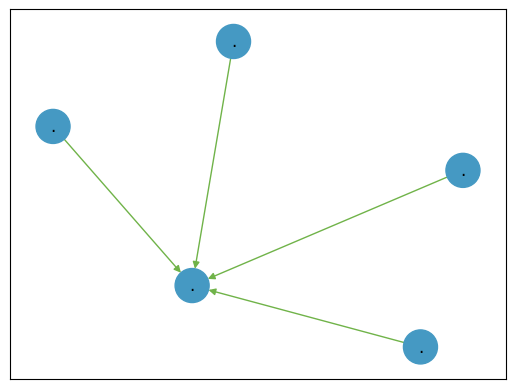

HeteroData(
  function={ x=[5, 768] },
  (function, internal_call, function)={ edge_index=[2, 4] }
)


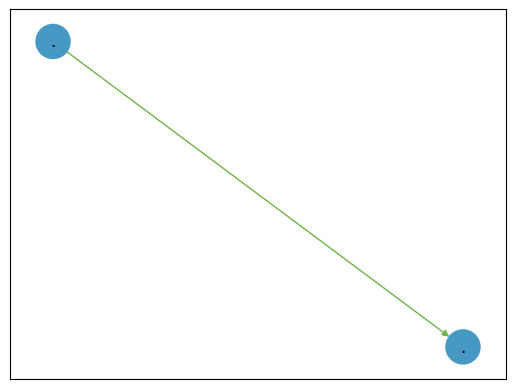

HeteroData(
  function={ x=[2, 768] },
  (function, internal_call, function)={ edge_index=[2, 1] }
)


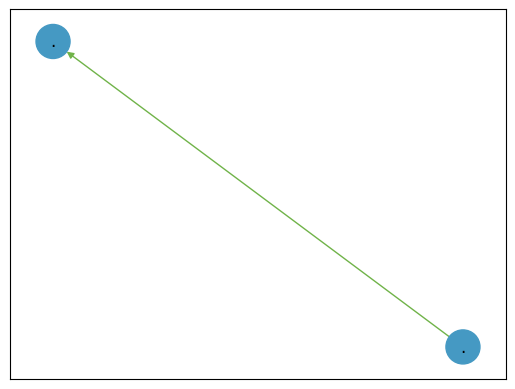

HeteroData(
  function={ x=[2, 768] },
  (function, internal_call, function)={ edge_index=[2, 1] }
)


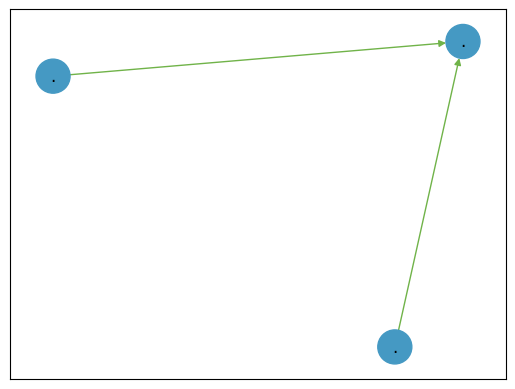

HeteroData(
  function={ x=[3, 768] },
  (function, internal_call, function)={ edge_index=[2, 2] }
)


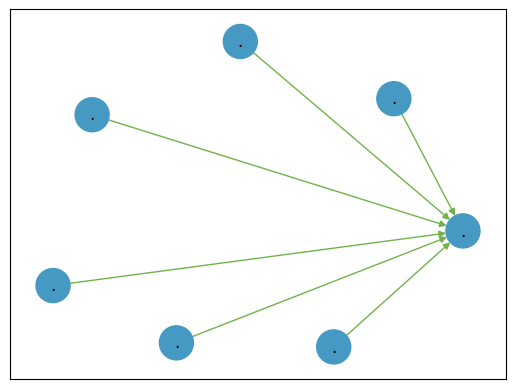

HeteroData(
  function={ x=[7, 768] },
  (function, internal_call, function)={ edge_index=[2, 6] }
)


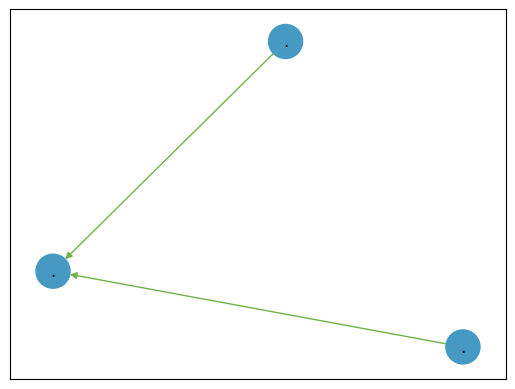

HeteroData(
  function={ x=[3, 768] },
  (function, internal_call, function)={ edge_index=[2, 2] }
)


In [88]:
# blacklist=[4,6,7,8,11,13,16,18,19,20,22,25,27,28,30,31,32,34]
for i in range(len(pyg_datasets_modified)):
    # if i in blacklist:
    #   continue
    subgraph=sample_from_graph_ensure(pyg_datasets_modified[i],7)
    draw_graph(subgraph)
    print(subgraph)

In [11]:
metadata = pyg_datasets_modified[1].metadata()
edge_types=metadata[1]
for edge_type in edge_types:
  edge_type_str = '__'.join(edge_type)
  print(edge_type_str)

function__internal_call__function


In [147]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv, global_mean_pool

class HeteroGNN(torch.nn.Module):
    def __init__(self, metadata, in_channels, hidden_channels, out_channels, num_layers=2, use_edge_features=False):
        super(HeteroGNN, self).__init__()

        self.node_types = metadata[0]
        self.edge_types = metadata[1]
        self.num_layers = num_layers
        self.use_edge_features = use_edge_features

        # first convolution
        first_conv_dict = {
            (src, rel, dst): SAGEConv(in_channels, hidden_channels)
            for src, rel, dst in self.edge_types
        }
        self.first_conv=HeteroConv(first_conv_dict)
        # middle convolutions
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers-2):
            conv_dict = {}
            for edge_type in self.edge_types:
                src, rel, dst = edge_type
                conv_dict[(src, rel, dst)] = SAGEConv(hidden_channels, hidden_channels)
            self.convs.append(HeteroConv(conv_dict))
        # final convloution
        final_conv_dict = {
            (src, rel, dst): SAGEConv(hidden_channels, out_channels)
            for src, rel, dst in self.edge_types
        }
        self.final_conv = HeteroConv(final_conv_dict)

        # Pooling layer to aggregate node embeddings into a graph embedding
        self.pool = global_mean_pool

    def forward(self, data):
        x_dict = {node_type: data[node_type].x for node_type in self.node_types}
        edge_index_dict = {edge_type: data[edge_type].edge_index for edge_type in self.edge_types}

        x_dict=self.first_conv(x_dict,edge_index_dict)
        for i in range(self.num_layers-2):
            print(i)
            x_dict = self.convs[i](x_dict, edge_index_dict)
            x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        x_dict = self.final_conv(x_dict, edge_index_dict)

        x = torch.cat([x_dict[node_type] for node_type in self.node_types], dim=0)
        # Since we have only one node type, pass zeros
        graph_embedding = self.pool(x, torch.zeros(x.size(0), dtype=torch.long))

        return graph_embedding

# Assuming pyg_datasets_modified[1] is a PyG dataset with metadata
metadata = pyg_datasets_modified[1].metadata()
model = HeteroGNN(metadata, in_channels=768, hidden_channels=64, out_channels=32)

# Forward pass to obtain graph embeddings
graph_embedding = model(pyg_datasets_modified[1])
print(graph_embedding)

tensor([[-0.0490,  0.0230, -0.0134,  0.2080,  0.0011, -0.1214,  0.1196, -0.1883,
         -0.1422,  0.0596, -0.0042, -0.1968, -0.2230, -0.0036,  0.0592,  0.0308,
         -0.1230, -0.0926, -0.1208, -0.0847, -0.0501, -0.0979, -0.0760,  0.0149,
         -0.2115, -0.1679, -0.0760,  0.0813, -0.0357, -0.0690,  0.0646,  0.0535]],
       grad_fn=<DivBackward0>)


More powerfull model, but need to fix bug

In [161]:
# import os.path as osp
# from typing import Dict, List, Union

# import torch
# import torch.nn.functional as F
# from torch import nn
# import torch_geometric
# from torch_geometric.nn import HANConv
# from torch_geometric import utils
# from torch_geometric.utils import k_hop_subgraph

# class HeteroGNN(torch.nn.Module):
#     def __init__(self, metadata, hidden_channels, out_channels, num_layers=2, use_edge_features=False):
#         super(HeteroGNN, self).__init__()

#         self.node_types = metadata[0]
#         self.edge_types = metadata[1]
#         self.num_layers = num_layers
#         self.use_edge_features = use_edge_features

#         # dictionary of GNN layers for each edge type
#         self.convs = torch.nn.ModuleList()
#         for _ in range(num_layers):
#             conv_dict = {}
#             for edge_type in self.edge_types:
#                 edge_type_str = '__'.join(edge_type)
#                 conv_dict[edge_type_str] = GATConv((-1, -1), hidden_channels, add_self_loops=False)
#             self.convs.append(HeteroConv(conv_dict))

#         final_conv_dict = {
#             edge_type: GATConv((-1, -1), out_channels)
#             for edge_type in self.edge_types
#         }
#         self.final_conv = HeteroConv(final_conv_dict)

#         # pooling layer to aggregate node embeddings into a graph embedding
#         self.pool = global_mean_pool

#     def forward(self, data):
#         x_dict = {node_type: data[node_type].x for node_type in self.node_types}
#         edge_index_dict = {edge_type: data[edge_type].edge_index for edge_type in self.edge_types}

#         for i in range(self.num_layers):
#             x_dict = self.convs[i](x_dict, edge_index_dict)
#             x_dict = {key: F.relu(x) for key, x in x_dict.items()}

#         x_dict = self.final_conv(x_dict, edge_index_dict)

#         x = torch.cat([x_dict[node_type] for node_type in self.node_types], dim=0)
#         # Since have only one node type, pass zeros
#         graph_embedding = self.pool(x, torch.zeros(x.size(0), dtype=torch.long))

#         return graph_embedding

# model = HeteroGNN(in_channels=-1, out_channels=3)

In [148]:
import random
from torch import nn
import torch_geometric

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch_geometric.is_xpu_available():
    device = torch.device('xpu')
else:
    device = torch.device('cpu')
data, model = data.to(device), model.to(device)

def train(model,optimizer,loss_fn, pyg_datasets_modified, num_iterations) -> float:
    model.train()

    total_loss=torch.tensor(0.0, requires_grad=True)
    for _ in range(num_iterations):
        optimizer.zero_grad()
        available_indices=[i for i in range(len(pyg_datasets_modified))]
        # Choose big graph
        random_positive_graph_index=random.choice(available_indices)
        available_indices.remove(random_positive_graph_index)
        positive_big_graph=pyg_datasets_modified[random_positive_graph_index]

        amount_nodes=random.choice([5, 7])
        # Assumption is that functions from one repository have <similar*> code
        positive_subgraph=sample_from_graph_ensure(positive_big_graph,amount_nodes)

        # Sample negative subgraphs
        negative_subgraphs=[]
        while available_indices:
            random_negative_graph_index=available_indices.pop()
            negative_big_graph=pyg_datasets_modified[random_negative_graph_index]
            negative_subgraphs.append(sample_from_graph_ensure(negative_big_graph,amount_nodes))

        # get graph level embeddings
        big_graph_emb=model(positive_big_graph)
        positive_subgraph_emb=model(positive_subgraph)
        negative_subgraph_embs = [model(negative_subgraph) for negative_subgraph in negative_subgraphs]

        # subgraph from big graph should have high cosine similarity
        loss_positive = loss_fn(big_graph_emb, positive_subgraph_emb)
        # subgraphs from another big graphs should have low cosine similarity
        negative_losses=[]
        for negative_subgraph_emb in negative_subgraph_embs:
            negative_loss=loss_fn(big_graph_emb, negative_subgraph_emb)
            # negative_loss=torch.min(negative_loss, torch.tensor(0.0))
            negative_losses.append(negative_loss)

        negative_losses=torch.stack(negative_losses)
        loss_negatives_cumulative=torch.sum(negative_losses)
        loss_negative=loss_negatives_cumulative/len(negative_subgraph_embs)

        # if similarity>0, keep it. if negative, make 0
        # loss_positive = torch.max(loss_positive, torch.tensor(0.0))
        loss=1-0.1*loss_positive+0.9*loss_negative
        total_loss = total_loss + loss

    total_loss.backward()
    optimizer.step()
    return total_loss.item() / num_iterations

@torch.no_grad()
def test(model, pyg_datasets_modified):
    model.eval()
    available_indices=[i for i in range(len(pyg_datasets_modified))]
    # Choose big graph, sample subgraph from it
    random_positive_graph_index=random.choice(available_indices)
    positive_big_graph=pyg_datasets_modified[random_positive_graph_index]
    amount_nodes=random.choice([5,7])
    positive_subgraph=sample_from_graph_ensure(positive_big_graph,amount_nodes)
    positive_subgraph_emb=model(positive_subgraph)

    # Rest big graphs embeddings
    big_graphs_embs=[]
    for big_graph in  pyg_datasets_modified:
        big_graphs_embs.append(model(big_graph))
    big_graphs_embs = torch.stack(big_graphs_embs)

    similarities=torch.matmul(big_graphs_embs.squeeze(1),positive_subgraph_emb.T.squeeze(1))
    _, indices=torch.sort(similarities,descending=True)
    # Find the place of the actual match
    place_of_actual_match = (indices == random_positive_graph_index).nonzero(as_tuple=True)[0].item()
    print('Place of actual match is', place_of_actual_match + 1, '/', len(pyg_datasets_modified))

    most_similar_big_graph_idx=similarities.argmax(dim=0).item()
    if random_positive_graph_index==most_similar_big_graph_idx:
        return True, similarities[random_positive_graph_index].item()
    else:
        return False, similarities[random_positive_graph_index]

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0005)
loss_fn=nn.CosineSimilarity()
metadata = pyg_datasets_modified[1].metadata()
model = HeteroGNN(metadata, in_channels=768, hidden_channels=64, out_channels=32)

for epoch in range(1, 50):
    loss=train(model, optimizer, loss_fn, pyg_datasets_modified, 20)
    found_flag,similarity=test(model, pyg_datasets_modified)
    print('train loss',loss)
    print('test',found_flag,similarity)

Place of actual match is 21 / 35
train loss 1.727817916870117
test False tensor(0.6716)
Place of actual match is 13 / 35
train loss 1.737704086303711
test False tensor(0.7584)
Place of actual match is 18 / 35
train loss 1.7440946578979493
test False tensor(0.6939)
Place of actual match is 23 / 35
train loss 1.7419794082641602
test False tensor(0.7184)
Place of actual match is 13 / 35
train loss 1.71820068359375
test False tensor(0.9221)
Place of actual match is 32 / 35
train loss 1.731338882446289
test False tensor(0.5153)
Place of actual match is 34 / 35
train loss 1.7297386169433593
test False tensor(0.4617)
Place of actual match is 29 / 35
train loss 1.7289115905761718
test False tensor(0.5259)
Place of actual match is 8 / 35
train loss 1.7356515884399415
test False tensor(0.7660)
